# Para trabajar con audio utilizaremos la siguiente librería

https://pypi.python.org/pypi/PySoundFile/0.8.1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os


Fijemonos cuáles son las locuciones que tenemos para cada caso

In [198]:
fpaths = []
labels = []
spoken = []
for f in os.listdir('audio'):
    for w in os.listdir('audio/' + f):
        fpaths.append('audio/' + f + '/' + w)
        labels.append(f)
        if f not in spoken:
            spoken.append(f)
print('Words spoken:', spoken)

Words spoken: ['banana', 'lime', 'peach', 'orange', 'pineapple', 'kiwi', 'apple']


In [199]:
from scipy.io import wavfile
from scipy import signal
data = np.zeros((len(fpaths), 32000))
maxsize = -1
for n,file in enumerate(fpaths):
    _, d = wavfile.read(file)
    data[n, :d.shape[0]] = d
    if d.shape[0] > maxsize:
        maxsize = d.shape[0]
data = data[:, :maxsize]

#Each sample file is one row in data, and has one entry in labels
print('Number of files total:', data.shape[0])
all_labels = np.zeros(data.shape[0])
for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n
    
print('Labels and label indices', all_labels)

Number of files total: 98
Labels and label indices [ 5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.]


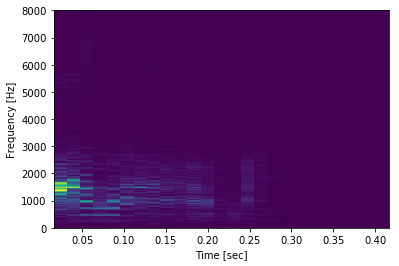

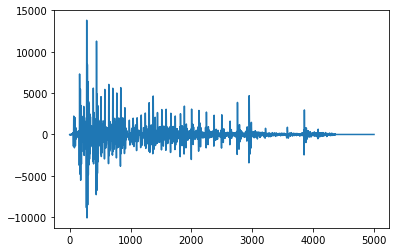

In [200]:
fs=16000
x=data[0,:]
f, t, Sxx = signal.spectrogram(x, fs,nperseg=512,window=signal.get_window('hamming', 512),noverlap=256)
plt.pcolormesh(t, f, np.sqrt(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
plt.plot(x[0:5000])
plt.show()

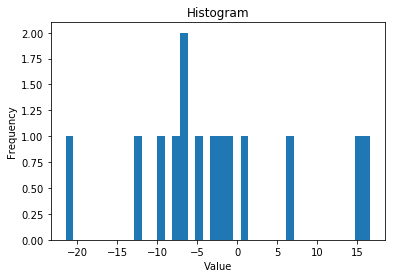

[[  2.10064168e+01  -1.15479379e+01  -3.34533691e+01  -4.39507378e+01
   -1.05508127e+01   1.48568737e+01  -2.50380166e+01   7.63550086e+00
   -2.02006024e+01  -2.41252521e+01   1.09777172e+01   1.29346438e+01
   -1.60404052e+01]
 [  2.10375583e+01  -6.89169820e+00  -3.95520506e+01  -3.83487843e+01
   -1.28247098e+01   1.66286793e+01  -2.94334896e+01   1.59735311e+01
   -2.72251528e+01  -1.63052360e+01   1.10323842e+01   9.78589257e+00
   -1.79549742e+01]
 [  1.93856272e+01   8.43637892e-01  -4.08119330e+01  -3.19996979e+01
   -2.11867201e+01  -6.36610551e+00  -3.77754150e+01  -6.54801361e-01
   -3.53529490e+01  -1.59887048e+01  -2.64594605e+00  -5.24479307e+00
   -1.67622541e+01]
 [  1.87704796e+01   3.93017175e+00  -2.99096897e+01  -2.51050822e+01
   -2.24793456e+01  -6.65680838e+00  -3.38649808e+01   1.15533948e+01
   -1.37018575e+01  -4.66463526e+00  -1.04668926e+01   6.91133692e+00
   -1.19294946e+01]
 [  1.93901720e+01   3.56776914e-01  -3.62708850e+01  -3.11438197e+01
   -1.9126

In [201]:
from python_speech_features import mfcc 
from python_speech_features import logfbank
from python_speech_features import base
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import numpy as np
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl

def mfcc_wav(file):
    (rate,sig) = wav.read(file)
    mfcc_feat = mfcc(sig,rate, winlen=512/rate, winstep=256/rate,nfft=512,appendEnergy=True)
    #fbank_feat = logfbank(sig,rate,nfft=512)
    return mfcc_feat

mfcc_feat=mfcc_wav("./audio/banana/banana02.wav")
plt.hist(mfcc_feat.T[5], bins=40)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()
print(mfcc_feat)

In [212]:
from os import listdir
ref_path="./audio/"
feats=np.zeros([1,13])
#for folder in sorted(listdir(ref_path)):
folder="banana"
for file in sorted(listdir(ref_path+folder)):
    abs_file=ref_path+folder+"/"+file
    feat_temp=mfcc_wav(abs_file)
    feats=np.vstack([feats, feat_temp])

In [213]:
from pomegranate import *
import numpy as np
# Left-to-right: each state is connected to itself and its direct successor
n_states=10
n_gauss=5
n_params=13
states=[State(GeneralMixtureModel([MultivariateGaussianDistribution(10*np.random.randn(n_params), np.random.rand(n_params,n_params)*np.eye(n_params)) for i in range(n_gauss)]), name="Estado"+str(j)) for j in range(n_states)]
model = HiddenMarkovModel()
model.add_states(states)
model.add_transition(model.start, states[0], 0.5)
for i in range(n_states-1):
    model.add_transition(states[i],states[i],0.5)
    model.add_transition(states[i],states[i+1],0.5)
model.add_transition(states[n_states-1],states[n_states-1],0.5)
model.add_transition(states[n_states-1],model.end,0.5)
model.bake()

In [215]:
model.fit(feats)

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 522, in pomegranate.bayes.BayesModel.from_summaries (pomegranate/bayes.c:8437)
  File "pomegranate/distributions.pyx", line 2262, in pomegranate.distributions.MultivariateGaussianDistribution.from_summaries (pomegranate/distributions.c:42722)
  File "/home/cselmo/Private/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 81, in cholesky
    check_finite=check_finite)
  File "/home/cselmo/Private/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 20, in _cholesky
    a1 = asarray_chkfinite(a)
  File "/home/cselmo/Private/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py", line 1215, in asarray_chkfinite
    "array must not contain infs or NaNs")
ValueError: array must not contain infs or NaNs


nan

In [196]:
model.dense_transition_matrix()

array([[ 0.5,  0.5,  0. ,  0. ,  0. ],
       [ 0. ,  0.5,  0.5,  0. ,  0. ],
       [ 0. ,  0. ,  0.5,  0. ,  0.5],
       [ 1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ]])

In [211]:
for folder in sorted(listdir(ref_path)):
    print(folder)
    for file in sorted(listdir(ref_path+folder)):
        abs_file=ref_path+folder+"/"+file
        feat_temp=mfcc_wav(abs_file)
        print(model.predict(feat_temp))

apple
[1 0 0 2 2 1 1 1 1 1 2 3]
[1 0 0 1 1 2 3 3 1 1 1]
[1 2 0 0 1 2 0 1 1 1 2 1]
[1 2 0 2 2 3 1 1 1 3 2 3]
[1 2 2 2 2 2 0 0 2 2 2]
[1 2 0 1 1 2 1 1 1 1 2 3]
[1 1 1 2 1 1 3 3 1 1 3 3 3 0]
[1 0 2 2 2 1 1 1 3 2 3 3 3]
[1 3 0 0 1 1 1 1 0 1 3 3 1]
[1 2 1 2 3 2 1 1 0 2 1 1 0]
[1 2 2 2 0 2 2 1 1 1 1 2 1]
[1 0 1 2 2 1 1 0 3 1 1 3 0]
[1 1 1 1 2 2 2 3 2 2 2 3 0]
[1 0 0 0 2 2 2 1 2 2 0 1 0]
banana
[1 3 2 1 1 1 1 1 1 1 1 2 2 1]
[1 3 3 0 1 1 1 1 1 1 1 1 1 1 2]
[1 0 3 1 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 1 1 2 1 1 1 1 3 1 2 1]
[1 0 0 0 0 0 1 1 1 1 2 2 3 3 0 0 0]
[1 0 0 0 2 1 1 1 1 0 2 1 3 0 2 3 0]
[1 3 0 0 2 2 0 0 0 0 1 2 2 3 0 1]
[1 3 0 2 2 0 0 2 2 1 1 2 3 2]
[1 3 0 0 2 2 2 1 0 1 1 1 1 1 1 2 2]
[1 3 1 0 1 1 1 1 1 1 2 0 2 1 2 0]
[1 3 0 1 1 1 1 1 1 1 2 0 3 3 1]
[1 3 3 0 2 2 1 1 1 1 1 2 0 2 2 0 0 0]
[1 3 0 0 1 1 1 1 1 1 1 1 1 0 3 2 2 1]
[1 3 1 2 1 2 1 1 1 1 1 2 1 3 1 2]
kiwi
[1 1 1 2 2 1 2 2 2 2 2]
[1 2 2 2 1 1 2 2 3 2 2]
[1 1 1 2 3 1 3 2 2 2 2]
[1 1 2 2 2 2 3 2 3 2 3 2]
[1 2 0 2 2 1 1 1 2 3 2 2 2]
[1 1 2

In [136]:
mfcc_feat=mfcc_wav("./audio/pineapple/pineapple02.wav")
model.predict(mfcc_feat)

array([2, 1, 1, 4, 1, 4, 4, 1, 1, 3, 4, 2, 2, 0, 4, 4, 2])

In [137]:
mfcc_feat=mfcc_wav("./audio/apple/apple02.wav")
model.predict(mfcc_feat)

array([2, 2, 2, 2, 2, 2, 0, 4, 4, 1, 4, 2])

In [335]:
from os import listdir
n_states=5
ref_path="./audio/"
feats=np.zeros([1,13])
transmat = np.zeros((n_states, n_states))
for i in range(n_states):
    if i == n_states-1:
        transmat[i, i] = 1.0
    else:
        transmat[i, i] = 0.5
        transmat[i, i+1] = 0.5
startprob = np.zeros(n_states)
startprob[0] = 1.0
model= {"banana":hmm.GMMHMM(n_components=n_states, n_mix=10, covariance_type='diag',params='mct',startprob_prior=startprob),
       "apple":hmm.GMMHMM(n_components=n_states, n_mix=10, covariance_type='diag',params='mct'),
       "lime":hmm.GMMHMM(n_components=n_states, n_mix=10, covariance_type='diag',params='mct'),
       "pineapple":hmm.GMMHMM(n_components=n_states, n_mix=10, covariance_type='diag',params='mct'),
        "orange":hmm.GMMHMM(n_components=n_states, n_mix=10, covariance_type='diag',params='mct'),
        "kiwi":hmm.GMMHMM(n_components=n_states, n_mix=10, covariance_type='diag',params='mct'), 
        "peach":hmm.GMMHMM(n_components=n_states, n_mix=10, covariance_type='diag',params='mct')
       }

for folder in sorted(listdir(ref_path)):
    feats=np.zeros([1,13])
    model[folder].transmat_ = transmat
    model[folder].startprob_ = startprob
    for file in sorted(listdir(ref_path+folder)):
        abs_file=ref_path+folder+"/"+file
        feat_temp=mfcc_wav(abs_file)
        feats=np.vstack([feats, feat_temp])
    model[folder].fit(feats)

In [336]:
mfcc_feat=mfcc_wav("./apple01.wav")
for folder in sorted(listdir(ref_path)):
    print(folder)
    print(model[folder].score(mfcc_feat))

apple
-519.277842071
banana
-1172.06162349
kiwi
-1545.26177197
lime
-816.859434632
orange
-844.394534137
peach
-1427.36195946
pineapple
-845.64307182


In [326]:
from os import listdir
n_states=10
ref_path="./audio/"
feats=np.zeros([1,13])
transmat = np.zeros((n_states, n_states))
for i in range(n_states):
    if i == n_states-1:
        transmat[i, i] = 1.0
    else:
        transmat[i, i] = 0.5
        transmat[i, i+1] = 0.5
startprob = np.zeros(n_states)
startprob[0] = 1.0
model= {"banana":hmm.GaussianHMM(n_components=n_states,covariance_type='diag'),
       "apple":hmm.GaussianHMM(n_components=n_states, covariance_type='diag'),
       "lime":hmm.GaussianHMM(n_components=n_states,covariance_type='diag'),
       "pineapple":hmm.GaussianHMM(n_components=n_states, covariance_type='diag'),
        "orange":hmm.GaussianHMM(n_components=n_states, covariance_type='diag'),
        "kiwi":hmm.GaussianHMM(n_components=n_states, covariance_type='diag'), 
        "peach":hmm.GaussianHMM(n_components=n_states, covariance_type='diag')
       }

for folder in sorted(listdir(ref_path)):
    feats=np.zeros([1,13])
    model[folder].transmat_=transmat
    model[folder].startprob_=startprob
    for file in sorted(listdir(ref_path+folder)):
        abs_file=ref_path+folder+"/"+file
        feat_temp=mfcc_wav(abs_file)
        feats=np.vstack([feats, feat_temp])

    model[folder].fit(feats)

In [327]:
mfcc_feat=mfcc_wav("./apple01.wav")
for folder in sorted(listdir(ref_path)):
    print(folder)
    print(model[folder].score(mfcc_feat))

apple
-463.230283534
banana
-789.983346741
kiwi
-1151.25678828
lime
-760.425507428
orange
-815.409500955
peach
-782.043194685
pineapple
-596.386080573


In [334]:
model["peach"].transmat_

array([[  3.30776449e-001,   8.91324597e-067,   3.77272510e-096,
          9.85710899e-002,   2.08258062e-045,   8.88127531e-040,
          3.38362214e-001,   1.11476985e-001,   2.10375040e-090,
          1.20813262e-001],
       [  5.53954184e-098,   6.36538410e-001,   7.08232155e-046,
          4.41688822e-002,   6.57778699e-180,   3.19292708e-001,
          2.95981802e-177,   3.70025842e-051,   2.93487140e-192,
          5.53968300e-019],
       [  1.25223178e-055,   1.71161033e-127,   4.07365758e-001,
          8.46559141e-122,   3.94713727e-001,   6.78609956e-111,
          9.95706177e-028,   6.93504163e-094,   1.58412480e-001,
          3.95080352e-002],
       [  2.34226552e-077,   1.98274399e-001,   2.36286860e-002,
          3.93332278e-001,   1.22146575e-112,   1.50758542e-001,
          4.44266976e-084,   5.32727260e-010,   3.37467515e-136,
          2.34006095e-001],
       [  1.79660234e-001,   4.27806005e-254,   3.34991147e-012,
          3.13656326e-130,   2.81542209e-00

In [272]:
feats.flatten().shape

(2288,)

In [273]:
2288/13

176.0